# 1) Setting up Spark Environment

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.3.0/spark-3.3.0-bin-hadoop3.tgz
!tar xf spark-3.3.0-bin-hadoop3.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-3.3.0-bin-hadoop3"

In [ ]:
import findspark
findspark.init()

In [ ]:

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, sum as spark_sum


spark = SparkSession.builder.appName("Airline").getOrCreate()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")

# 2) Loading the Data Set

In [ ]:
data = spark.read.csv("/content/airline_passenger_satisfaction.csv", header=True, inferSchema=True)
data.show()

+---+------+---+-------------+--------------+--------+---------------+---------------+-------------+--------------------------------------+----------------------+----------------+---------------+-------------+----------------+------------+----------------+-----------+--------------+-----------------+----------------------+-----------------------+----------------+--------------------+
| ID|Gender|Age|Customer Type|Type of Travel|   Class|Flight Distance|Departure Delay|Arrival Delay|Departure and Arrival Time Convenience|Ease of Online Booking|Check-in Service|Online Boarding|Gate Location|On-board Service|Seat Comfort|Leg Room Service|Cleanliness|Food and Drink|In-flight Service|In-flight Wifi Service|In-flight Entertainment|Baggage Handling|        Satisfaction|
+---+------+---+-------------+--------------+--------+---------------+---------------+-------------+--------------------------------------+----------------------+----------------+---------------+-------------+----------------+

In [ ]:
data.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Customer Type: string (nullable = true)
 |-- Type of Travel: string (nullable = true)
 |-- Class: string (nullable = true)
 |-- Flight Distance: integer (nullable = true)
 |-- Departure Delay: integer (nullable = true)
 |-- Arrival Delay: integer (nullable = true)
 |-- Departure and Arrival Time Convenience: integer (nullable = true)
 |-- Ease of Online Booking: integer (nullable = true)
 |-- Check-in Service: integer (nullable = true)
 |-- Online Boarding: integer (nullable = true)
 |-- Gate Location: integer (nullable = true)
 |-- On-board Service: integer (nullable = true)
 |-- Seat Comfort: integer (nullable = true)
 |-- Leg Room Service: integer (nullable = true)
 |-- Cleanliness: integer (nullable = true)
 |-- Food and Drink: integer (nullable = true)
 |-- In-flight Service: integer (nullable = true)
 |-- In-flight Wifi Service: integer (nullable = true)
 |-- In-

In [ ]:
data.describe().show()

+-------+-----------------+------+------------------+-------------+--------------+------------+------------------+------------------+------------------+--------------------------------------+----------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+----------------------+-----------------------+------------------+--------------------+
|summary|               ID|Gender|               Age|Customer Type|Type of Travel|       Class|   Flight Distance|   Departure Delay|     Arrival Delay|Departure and Arrival Time Convenience|Ease of Online Booking|  Check-in Service|   Online Boarding|     Gate Location|  On-board Service|      Seat Comfort|  Leg Room Service|       Cleanliness|    Food and Drink| In-flight Service|In-flight Wifi Service|In-flight Entertainment|  Baggage Handling|        Satisfaction|
+-------+-----------------+------+------------------+-

In [ ]:
# To calculate the count of null values for each column
null_counts = data.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in data.columns])

# To show the null counts for each column
null_counts.show()

+---+------+---+-------------+--------------+-----+---------------+---------------+-------------+--------------------------------------+----------------------+----------------+---------------+-------------+----------------+------------+----------------+-----------+--------------+-----------------+----------------------+-----------------------+----------------+------------+
| ID|Gender|Age|Customer Type|Type of Travel|Class|Flight Distance|Departure Delay|Arrival Delay|Departure and Arrival Time Convenience|Ease of Online Booking|Check-in Service|Online Boarding|Gate Location|On-board Service|Seat Comfort|Leg Room Service|Cleanliness|Food and Drink|In-flight Service|In-flight Wifi Service|In-flight Entertainment|Baggage Handling|Satisfaction|
+---+------+---+-------------+--------------+-----+---------------+---------------+-------------+--------------------------------------+----------------------+----------------+---------------+-------------+----------------+------------+------------

In [ ]:
# To count the total number of rows in the DataFrame
total_rows = data.count()

# To count the number of rows after dropping rows with any null values
non_null_rows = data.dropna().count()

# To calculate the percentage of rows with at least one null value
percentage_null_rows = ((total_rows - non_null_rows) / total_rows) * 100

# To Display the calculated percentage
print("Percentage of rows with at least one null value: {:.2f}%".format(percentage_null_rows))

Percentage of rows with at least one null value: 0.30%


In [ ]:
# Specifying  the column to fill missing values
column_to_fill = 'Arrival Delay'

# Calculating the median value using approxQuantile
quantiles = data.approxQuantile(column_to_fill, [0.5], 0.01)  # 0.5 represents the median
median_value = quantiles[0]

# Filling missing values with the calculated median
data_filled = data.withColumn(column_to_fill, when(col(column_to_fill).isNull(), median_value).otherwise(col(column_to_fill)))

# To Show the updated DataFrame with missing values filled
data_filled.show()

+---+------+---+-------------+--------------+--------+---------------+---------------+-------------+--------------------------------------+----------------------+----------------+---------------+-------------+----------------+------------+----------------+-----------+--------------+-----------------+----------------------+-----------------------+----------------+--------------------+
| ID|Gender|Age|Customer Type|Type of Travel|   Class|Flight Distance|Departure Delay|Arrival Delay|Departure and Arrival Time Convenience|Ease of Online Booking|Check-in Service|Online Boarding|Gate Location|On-board Service|Seat Comfort|Leg Room Service|Cleanliness|Food and Drink|In-flight Service|In-flight Wifi Service|In-flight Entertainment|Baggage Handling|        Satisfaction|
+---+------+---+-------------+--------------+--------+---------------+---------------+-------------+--------------------------------------+----------------------+----------------+---------------+-------------+----------------+

In [ ]:
# To count the number of duplicated rows
duplicated_count = data.groupBy(data.columns).count().where(col('count') > 1).count()

# Displaying the number of duplicated rows
print("Number of duplicated rows: ", duplicated_count)

Number of duplicated rows:  0


In [ ]:
# Dropping the 'ID' column
columns_to_keep = [col for col in data.columns if col != 'ID']
data_without_id = data.select(columns_to_keep)

# Showing the DataFrame without the 'ID' column
data_without_id.show()

+------+---+-------------+--------------+--------+---------------+---------------+-------------+--------------------------------------+----------------------+----------------+---------------+-------------+----------------+------------+----------------+-----------+--------------+-----------------+----------------------+-----------------------+----------------+--------------------+
|Gender|Age|Customer Type|Type of Travel|   Class|Flight Distance|Departure Delay|Arrival Delay|Departure and Arrival Time Convenience|Ease of Online Booking|Check-in Service|Online Boarding|Gate Location|On-board Service|Seat Comfort|Leg Room Service|Cleanliness|Food and Drink|In-flight Service|In-flight Wifi Service|In-flight Entertainment|Baggage Handling|        Satisfaction|
+------+---+-------------+--------------+--------+---------------+---------------+-------------+--------------------------------------+----------------------+----------------+---------------+-------------+----------------+------------

# 3) Explanatory Data Analysis :-

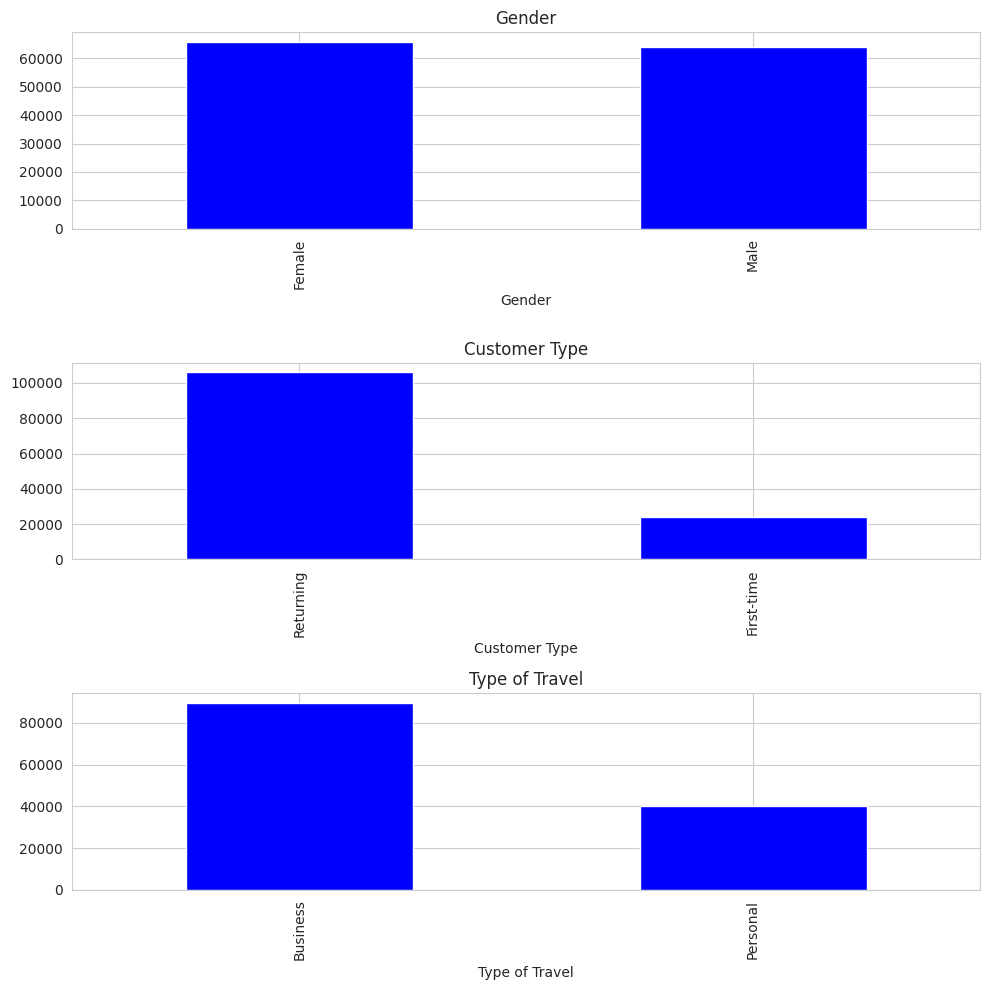

In [ ]:
# Converting the PySpark DataFrame to Pandas DataFrame for visualization
data_pd = data.select('Gender', 'Customer Type', 'Type of Travel').toPandas()

# Plotting the bar chart
fig, axs = plt.subplots(3, 1, figsize=(10, 10))

for i, col in enumerate(['Gender', 'Customer Type', 'Type of Travel']):
    data_pd[col].value_counts().plot(kind='bar', ax=axs[i], color='blue')
    axs[i].set_title(col)

plt.tight_layout()
plt.show()

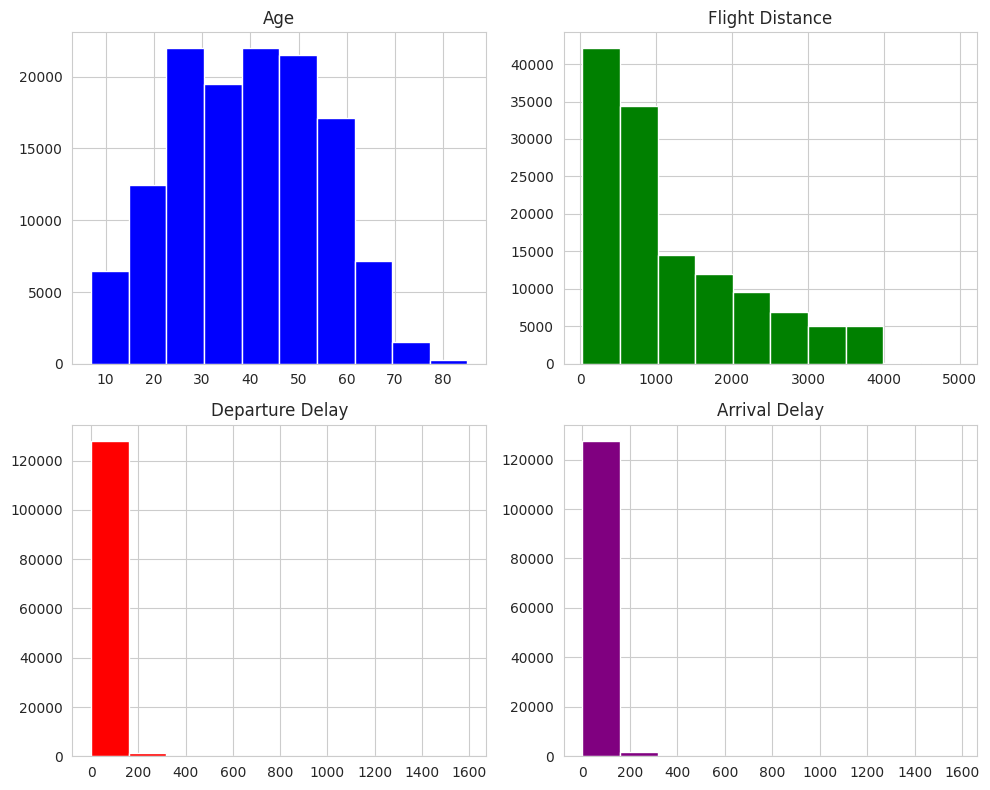

In [ ]:
# Converting PySpark DataFrame to Pandas DataFrame for visualization
data_pd_numeric = data.select('Age', 'Flight Distance', 'Departure Delay', 'Arrival Delay').toPandas()

# Defining colors for each histogram column
colors = ['blue', 'green', 'red', 'purple']

# Plotting the histograms with different colors for each column
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

for i, col in enumerate(data_pd_numeric.columns):
    row_index = i // 2
    col_index = i % 2
    data_pd_numeric[col].hist(ax=axs[row_index, col_index], color=colors[i])
    axs[row_index, col_index].set_title(col)

plt.tight_layout()
plt.show()

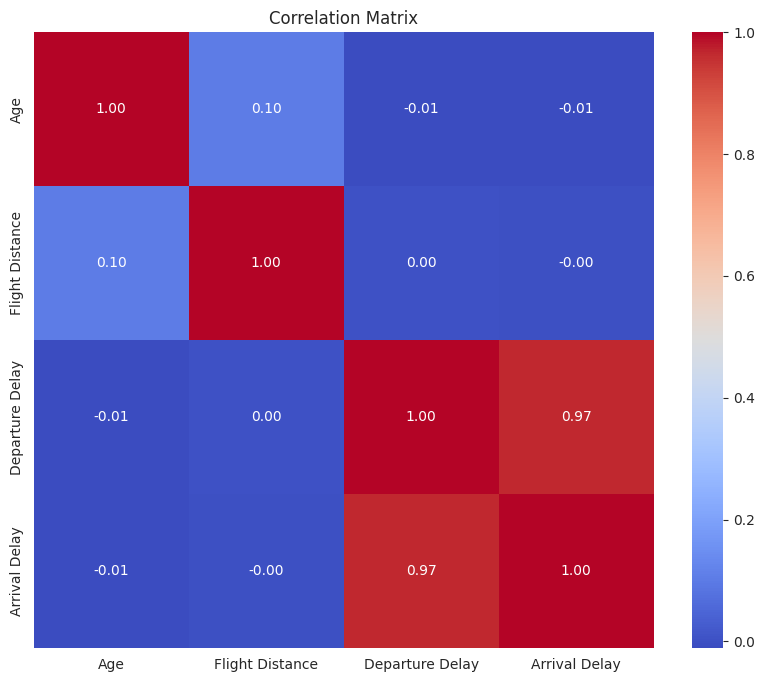

In [ ]:
# To calculate correlation matrix
correlation_matrix = data_pd_numeric.corr()

# Plotting the heatmap for correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


# (i) What is the level of airline passenger satisfaction based on Departure Delay and Arrival Delay?

In [ ]:
from pyspark.sql import functions as F

# Calculating the mean of Departure Delay and Arrival Delay grouped by Satisfaction
satisfaction_departure_delay_mean = data.groupBy('Satisfaction').agg(F.mean('Departure Delay').alias('Mean_Departure_Delay'))
satisfaction_arrival_delay_mean = data.groupBy('Satisfaction').agg(F.mean('Arrival Delay').alias('Mean_Arrival_Delay'))

# printing the results
print("Mean Departure Delay grouped by Satisfaction:")
satisfaction_departure_delay_mean.show()

print("Mean Arrival Delay grouped by Satisfaction:")
satisfaction_arrival_delay_mean.show()

Mean Departure Delay grouped by Satisfaction:
+--------------------+--------------------+
|        Satisfaction|Mean_Departure_Delay|
+--------------------+--------------------+
|Neutral or Dissat...|  16.406837118117956|
|           Satisfied|  12.509782377543063|
+--------------------+--------------------+

Mean Arrival Delay grouped by Satisfaction:
+--------------------+------------------+
|        Satisfaction|Mean_Arrival_Delay|
+--------------------+------------------+
|Neutral or Dissat...| 17.05599180607716|
|           Satisfied| 12.53385944331876|
+--------------------+------------------+



/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:1080: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


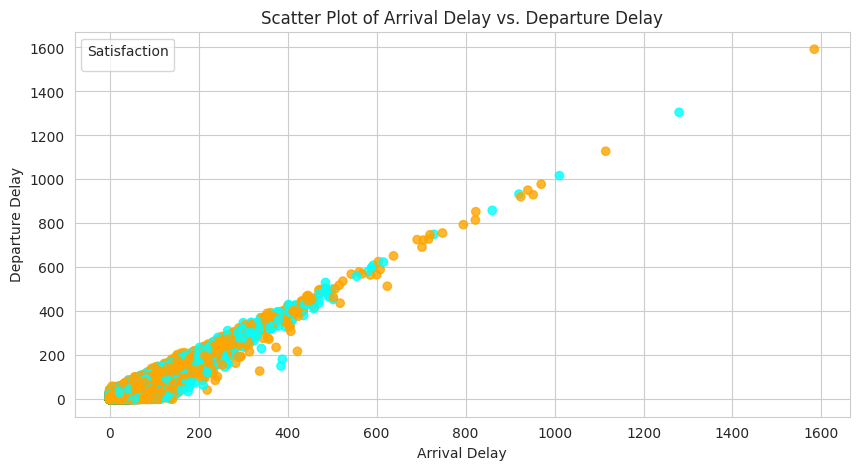

In [ ]:
# Converting the PySpark DataFrame to Pandas DataFrame
data_pd = data.select('Arrival Delay', 'Departure Delay', 'Satisfaction').toPandas()

# Normalizing the case in 'Satisfaction' column for consistency
data_pd['Satisfaction'] = data_pd['Satisfaction'].str.lower()  # Convert to lowercase

# Setting the plot size
plt.figure(figsize=(10, 5), dpi=100)

# Defining custom colors based on lowercase keys
colors = {'satisfied': 'cyan', 'neutral or dissatisfied': 'orange'}  # Define custom colors
scatter = plt.scatter(data_pd['Arrival Delay'], data_pd['Departure Delay'],
                       c=data_pd['Satisfaction'].apply(lambda x: colors.get(x, 'gray')),
                       alpha=0.8)

# Customize plot labels and legend
plt.title('Scatter Plot of Arrival Delay vs. Departure Delay')
plt.xlabel('Arrival Delay')
plt.ylabel('Departure Delay')
plt.legend(handles=scatter.legend_elements()[0], labels=colors.keys(), title='Satisfaction')

# Show the plot
plt.show()

# Observations:

Departure and arrival delays seem to have a linear relationship.
There was 1 passenger who was satisfied even after a delay of 1300 minutes.

# (ii) What is the level of airline passenger satisfaction when viewed based on Flight Distance?

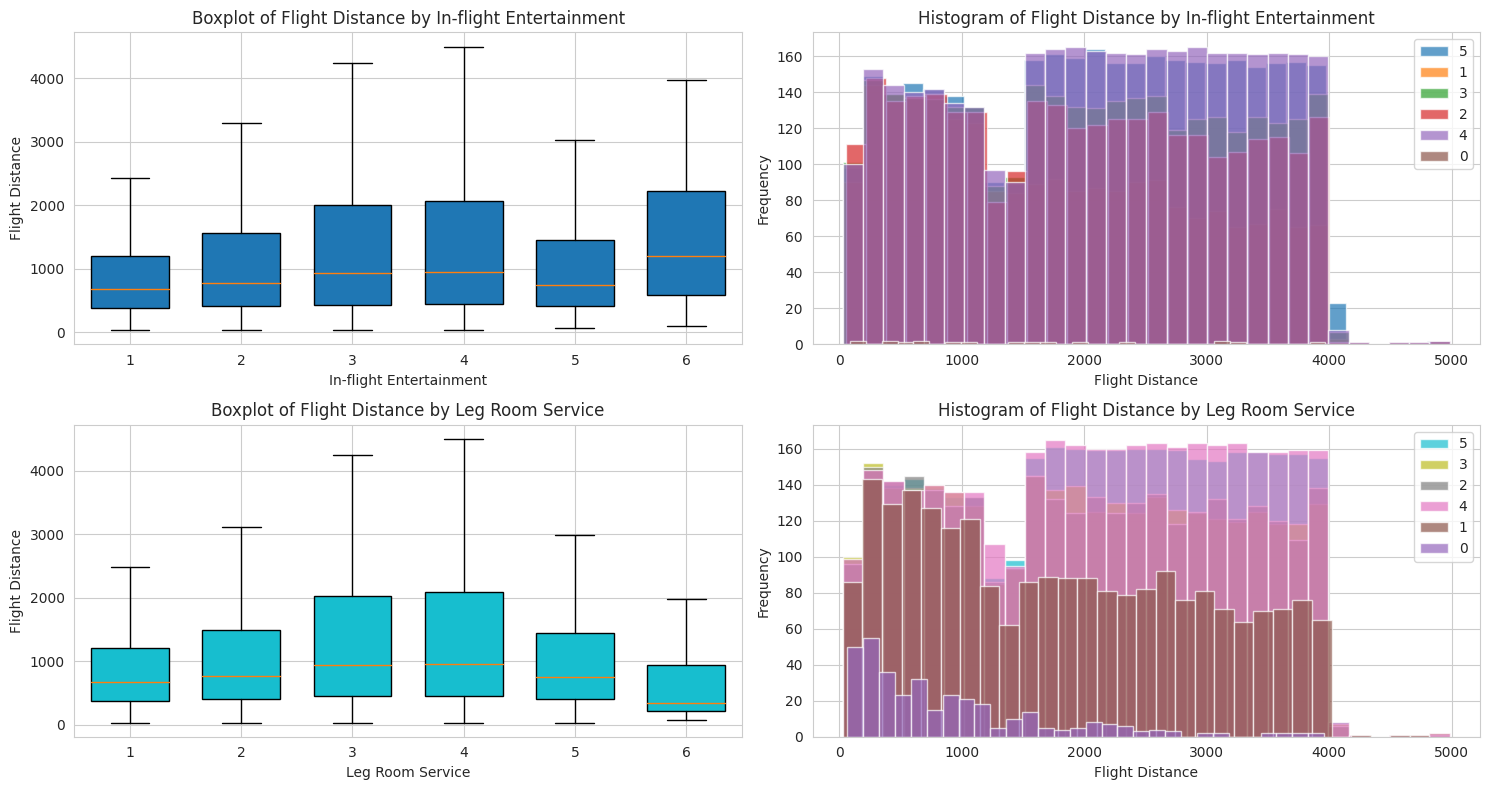

In [ ]:
# Defining custom color palettes
palette_gnuplot2 = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
palette_gnuplot2_r = list(reversed(palette_gnuplot2))

# Creating subplots for visualization
fig, ax = plt.subplots(2, 2, figsize=(15, 8))

# Plotting boxplot for "In-flight Entertainment" vs. "Flight Distance"
data_boxplot1 = data.groupBy("In-flight Entertainment").agg(F.collect_list("Flight Distance").alias("Flight_Distance"))
boxplot_data1 = data_boxplot1.toPandas()
ax[0, 0].boxplot(boxplot_data1["Flight_Distance"], patch_artist=True, widths=0.7, showfliers=False,
                 boxprops=dict(facecolor=palette_gnuplot2[0]))
ax[0, 0].set_xlabel("In-flight Entertainment")
ax[0, 0].set_ylabel("Flight Distance")
ax[0, 0].set_title("Boxplot of Flight Distance by In-flight Entertainment")

# Plotting stacked histogram for "Flight Distance" with "In-flight Entertainment" as hue
histplot_data1 = data.groupBy("Flight Distance", "In-flight Entertainment").count().toPandas()
sns_palette_map = {entertainment: palette_gnuplot2[i] for i, entertainment in enumerate(histplot_data1["In-flight Entertainment"].unique())}
for entertainment, color in sns_palette_map.items():
    histplot_subset = histplot_data1[histplot_data1["In-flight Entertainment"] == entertainment]
    ax[0, 1].hist(histplot_subset["Flight Distance"], bins=30, alpha=0.7, color=color, label=entertainment)
ax[0, 1].set_xlabel("Flight Distance")
ax[0, 1].set_ylabel("Frequency")
ax[0, 1].set_title("Histogram of Flight Distance by In-flight Entertainment")
ax[0, 1].legend()

# Plotting boxplot for "Leg Room Service" vs. "Flight Distance"
data_boxplot2 = data.groupBy("Leg Room Service").agg(F.collect_list("Flight Distance").alias("Flight_Distance"))
boxplot_data2 = data_boxplot2.toPandas()
ax[1, 0].boxplot(boxplot_data2["Flight_Distance"], patch_artist=True, widths=0.7, showfliers=False,
                 boxprops=dict(facecolor=palette_gnuplot2_r[0]))
ax[1, 0].set_xlabel("Leg Room Service")
ax[1, 0].set_ylabel("Flight Distance")
ax[1, 0].set_title("Boxplot of Flight Distance by Leg Room Service")

# Plotting stacked histogram for "Flight Distance" with "Leg Room Service" as hue
histplot_data2 = data.groupBy("Flight Distance", "Leg Room Service").count().toPandas()
sns_palette_map_r = {service: palette_gnuplot2_r[i] for i, service in enumerate(histplot_data2["Leg Room Service"].unique())}
for service, color in sns_palette_map_r.items():
    histplot_subset = histplot_data2[histplot_data2["Leg Room Service"] == service]
    ax[1, 1].hist(histplot_subset["Flight Distance"], bins=30, alpha=0.7, color=color, label=service)
ax[1, 1].set_xlabel("Flight Distance")
ax[1, 1].set_ylabel("Frequency")
ax[1, 1].set_title("Histogram of Flight Distance by Leg Room Service")
ax[1, 1].legend()

plt.tight_layout()
plt.show()

# Observations:

The farther the flight distance traveled by airplane passengers, the longer the passengers will be on the flight.
So that passengers feel more satisfied with the entertainment during the flight and the extra distance between seats on the plane (leg room) (on average).

# (iii) What is the level of airline passenger satisfaction when viewed based on Flight Distance and Departure Delay?

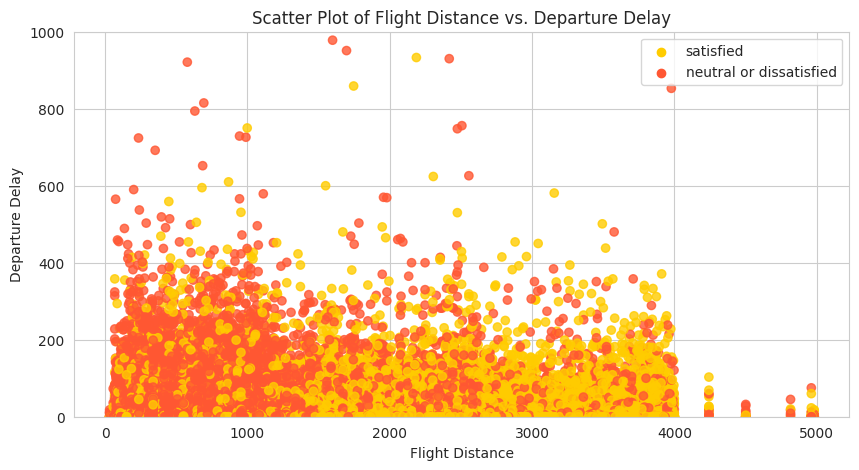

In [ ]:
# Defining the custom color map for satisfaction levels
color_map = {
    'satisfied': '#FFCC00',  # Yellow for satisfied
    'neutral or dissatisfied': '#FF5733'  # Orange for neutral or dissatisfied
}

# Extracting required columns and convert to Pandas DataFrame for plotting
data_pd = data.select('Flight Distance', 'Departure Delay', 'Satisfaction').toPandas()

# To Create scatter plot with customized settings
plt.figure(figsize=(10, 5), dpi=100)
plt.scatter(data_pd['Flight Distance'], data_pd['Departure Delay'],
            c=data_pd['Satisfaction'].apply(lambda x: color_map.get(x.lower(), 'gray')),  # Use lowercase for matching
            alpha=0.8)

# Customize plot labels, title, legend, and limits
plt.xlabel('Flight Distance')
plt.ylabel('Departure Delay')
plt.title('Scatter Plot of Flight Distance vs. Departure Delay')

# Create custom legend for satisfaction levels
for label, color in color_map.items():
    plt.scatter([], [], color=color, label=label)  # Create dummy scatter plot for legend
plt.legend()

# Set y-axis limit
plt.ylim(0, 1000)
plt.show()


# Observations:

It turns out that the longer the flight, the majority of passengers feel fine with the slight delay in departure.
Meanwhile, in comparison, departure delays are not a factor for long-distance flights. However, travelers with short flight distances seem unhappy with the delayed departure.

# 4) Machine Learning Models

# (i) Random Forest Classifier

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline


# Dropping rows with any null values from the DataFrame
cleaned_data = data.dropna()

# Defining feature columns (excluding non-numeric and target columns)
non_feature_columns = ['Satisfaction', 'Gender', 'Customer Type', 'Type of Travel', 'Class']
feature_columns = [col for col in cleaned_data.columns if col not in non_feature_columns]

label_indexer = StringIndexer(inputCol='Satisfaction', outputCol='label')
indexers = [
    StringIndexer(inputCol=column, outputCol=column + "_index", handleInvalid="keep")
    for column in ['Gender', 'Customer Type', 'Type of Travel', 'Class']
]
encoders = [
    OneHotEncoder(inputCols=[column + "_index"], outputCols=[column + "_encoded"])
    for column in ['Gender', 'Customer Type', 'Type of Travel', 'Class']
]

# Assembling feature columns into a single vector column named 'features'
assembler = VectorAssembler(inputCols=feature_columns + ['Gender_encoded', 'Customer Type_encoded',
                                                         'Type of Travel_encoded', 'Class_encoded'],
                            outputCol='features')

# Defining the RandomForestClassifier
rf = RandomForestClassifier(featuresCol="features", labelCol="label")

# Creating a Pipeline with all the stages
pipeline = Pipeline(stages=indexers + encoders + [label_indexer, assembler, rf])
model = pipeline.fit(cleaned_data)


In [ ]:
# Defining the RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

rf = RandomForestClassifier(featuresCol="features", labelCol="label")

# To Create a Pipeline with all the stages
pipeline = Pipeline(stages=indexers + encoders + [label_indexer, assembler, rf])

# Fitting the pipeline on the cleaned data
model = pipeline.fit(cleaned_data)

# To Make predictions on the cleaned data
predictions = model.transform(cleaned_data)

# Compute ROC and PR metrics using BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
areaUnderROC = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
areaUnderPR = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})

print("Area Under ROC:", areaUnderROC)
print("Area Under PR:", areaUnderPR)


Area Under ROC: 0.9706730100074763
Area Under PR: 0.964814555390083


In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Evaluating predictions using MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# Computing accuracy
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})

# To Compute precision
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})

# Computing recall
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# To Compute F1 score
f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

# Printing evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9201078100504297
Precision: 0.9200419596834476
Recall: 0.9201078100504297
F1 Score: 0.9200455443183532


# (ii) Decision Tree Classifier

In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

label_indexer = StringIndexer(inputCol='Satisfaction', outputCol='label')

# Preparing data for classification
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
data_features = assembler.transform(data_filled)

# Splitting the data into train and test sets
train_data, test_data = data_features.randomSplit([0.8, 0.2], seed=123)
label_indexer_model = label_indexer.fit(train_data)

# Transforming the train and test data with the StringIndexer model
train_data_transformed = label_indexer_model.transform(train_data)
test_data_transformed = label_indexer_model.transform(test_data)

# To train a Decision Tree Classifier
dt = DecisionTreeClassifier(labelCol='label', featuresCol='features')
dt_model = dt.fit(train_data_transformed)

# Make predictions on the test data
predictions = dt_model.transform(test_data_transformed)

# Evaluating the model's accuracy on the test data
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)

print("Decision Tree Classifier Accuracy:", accuracy)


Decision Tree Classifier Accuracy: 0.8704226441359576


In [ ]:
# Importing required metric evaluators
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Evaluating precision, recall, and F1 score in addition to accuracy
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction')

# Calculating accuracy
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: 'accuracy'})

# Calculating precision
precision = evaluator.evaluate(predictions, {evaluator.metricName: 'weightedPrecision'})

# Calculating recall
recall = evaluator.evaluate(predictions, {evaluator.metricName: 'weightedRecall'})

# Calculating F1 score
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: 'f1'})

# Printing evaluation metrics
print("Decision Tree Classifier Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)


Decision Tree Classifier Metrics:
Accuracy: 0.8704226441359576
Precision: 0.870621352708619
Recall: 0.8704226441359577
F1 Score: 0.8698502460606972


# (iii) KNN Classifier

In [ ]:
# To Convert Spark DataFrame to Pandas DataFrame for scikit-learn
data_pd = data_filled.select(feature_columns + ['Satisfaction']).toPandas()

# Normalizing features for KNN
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data_pd[feature_columns])

# Train-test split for KNN
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaled_features, data_pd['Satisfaction'], test_size=0.2, random_state=123)

# Apply KNN using scikit-learn
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
result = knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(y_pred)
knn_accuracy = knn.score(X_test, y_test)

print("KNN Classifier Accuracy:", knn_accuracy)


['Neutral or Dissatisfied' 'Satisfied' 'Neutral or Dissatisfied' ...
 'Satisfied' 'Satisfied' 'Neutral or Dissatisfied']
KNN Classifier Accuracy: 0.9140745303356945


In [ ]:
# Importing required metric evaluators
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculating precision, recall, and F1 score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Printing evaluation metrics
print("KNN Classifier Metrics:")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


KNN Classifier Metrics:
Precision: 0.9143996424018767
Recall: 0.9140745303356945
F1 Score: 0.9137823411268324


In [ ]:
import joblib
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

In [ ]:
joblib.dump(knn, 'knn_model.pkl')

['knn_model.pkl']

In [ ]:
from sklearn.preprocessing import StandardScaler


passenger_data = {
    'ID': 2345,
    'Gender': 'Female',
    'Age': 35,
    'Customer Type': 'Returning',
    'Type of Travel': 'Business',
    'Class': 'Business',
    'Flight Distance': 821,
    'Departure Delay': 26,
    'Arrival Delay': 39,
    'Departure and Arrival Time Convenience': 2,
    'Ease of Online Booking': 2,
    'Check-in Service': 3,
    'Online Boarding': 5,
    'Gate Location': 2,
    'On-board Service': 5,
    'Seat Comfort': 4,
    'Leg Room Service': 5,
    'Cleanliness': 5,
    'Food and Drink': 3,
    'In-flight Service': 5,
    'In-flight Wifi Service': 2,
    'In-flight Entertainment': 5,
    'Baggage Handling': 5
}


passenger_features = scaler.transform([[passenger_data[feature] for feature in data_pd.columns[:-1]]])


satisfaction_prediction = knn.predict(passenger_features)
print(satisfaction_prediction)




['Satisfied']


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%writefile /content/drive/MyDrive/streamlit_app.py

Overwriting /content/drive/MyDrive/streamlit_app.py


In [ ]:
pip install pyngrok

In [ ]:
!ngrok authtoken 2fmunXXFTkjyYsDXmhO7ImqL2Ks_69u1ogV4xszMZXXSZsb7k

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
from pyngrok import ngrok


ngrok.kill()


ngrok.set_auth_token("2fmunXXFTkjyYsDXmhO7ImqL2Ks_69u1ogV4xszMZXXSZsb7k")


In [ ]:
public_url = ngrok.connect(addr="8501", proto="http")

In [ ]:
print("Ngrok Tunnel URL:", public_url)

!streamlit run --server.port 8501 /content/drive/MyDrive/streamlit_app.py

Ngrok Tunnel URL: NgrokTunnel: "https://8aec-34-73-119-23.ngrok-free.app" -> "http://localhost:8501"



  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.73.119.23:8501

